## Get data

In [1]:
#imports
from astroquery.gaia import Gaia
import pandas as pd 
import seaborn as sns
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
#gaia query

job = Gaia.launch_job_async("SELECT ALL gaia_source.source_id,gaia_source.ra,gaia_source.dec,\
gaia_source.pmra,gaia_source.pmdec,gaia_source.phot_bp_mean_mag FROM gaiadr2.gaia_source WHERE CONTAINS\
(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',229.226,7.002,0.3))=1")  
                           # AND  \(gaiadr2.gaia_source.phot_bp_mean_mag<=20)")

Query finished.


In [3]:
#get resulting gaia datatable
r = job.get_results() #print(r['ra','dec'])
df_gaia = r.to_pandas()

In [4]:
#read apt datatable
filename = "pi26133_001.csv"
df_apt_ = pd.read_csv(filename) 
df_apt = df_apt_[['CentroidRA', 'CentroidDec','Magnitude', 'MagUncertainty']]

## Plots

Text(0.5,1,'Position match')

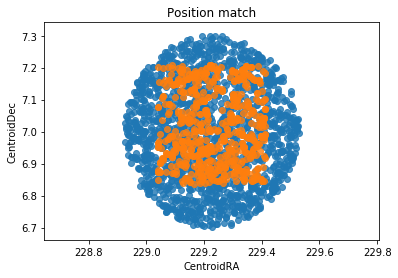

In [5]:
#check ra and dec matching
sns.regplot('ra', 'dec', data=df_gaia, fit_reg = False)
sns.regplot('CentroidRA', 'CentroidDec', data=df_apt, fit_reg = False).set_title("Position match")

In [7]:
maxdiff = 0.001
querystr = "diff<" + str(maxdiff)
df = pd.DataFrame(columns=['ra','dec','phot_bp_mean_mag','pmra','pmdec',\
                           'CentroidRA','CentroidDec','Magnitude','diff'])
dist = scipy.spatial.distance.cdist(df_apt[['CentroidRA', 'CentroidDec']], df_gaia[['ra', 'dec']]) 
min_dist = np.argmin(dist, axis=1) 

m = 0
while m < len(df_apt): #apt (6)
    n = min_dist[m]    #gaia (8)
    df = df.append({'ra': df_gaia['ra'][n], 'dec': df_gaia['dec'][n],\
                    'phot_bp_mean_mag': df_gaia['phot_bp_mean_mag'][n],\
                    'pmra': df_gaia['pmra'][n], 'pmdec': df_gaia['pmdec'][n],\
                    'CentroidRA': df_apt['CentroidRA'][m],'CentroidDec': df_apt['CentroidDec'][m],\
                    'Magnitude': df_apt['Magnitude'][m],\
                    'diff': dist[m][n]
                   }, ignore_index=True)
    m+=1


df = df.query(querystr)
df = df.sort_values('diff').drop_duplicates('ra')
df = df.sort_values('diff').drop_duplicates('CentroidRA')
#df= df.reset_index(drop=True)

/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of difference in match')

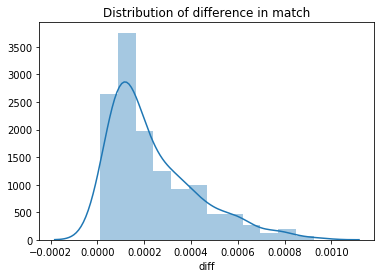

In [8]:
sns.distplot(df['diff']).set_title('Distribution of difference in match')

In [15]:
#new vars
df['Δra'] = df.apply(lambda row: row.ra - row.CentroidRA, axis = 1) 
df['Δdec'] = df.apply(lambda row: row.dec - row.CentroidDec, axis = 1) 
df['Δmag'] = df.apply(lambda row: row.Magnitude - row.phot_bp_mean_mag, axis = 1) 

#subset
df_filtered = df.query('diff<0.0002')

/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'dec vs. Δdec')

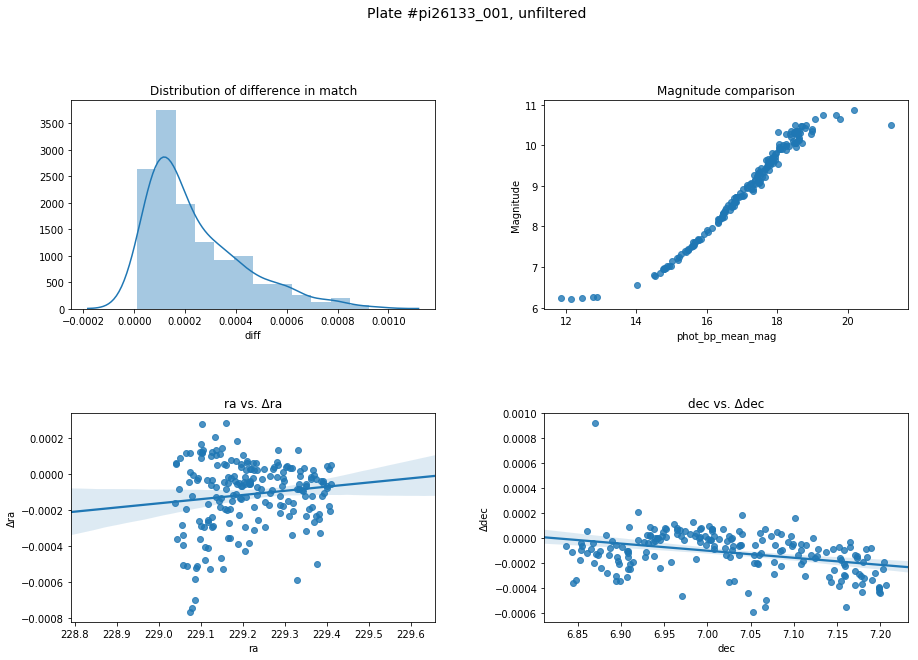

In [72]:
fig = plt.figure(figsize=(15,10))
title = fig.suptitle("Plate #pi26133_001, unfiltered", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3, hspace=0.5)

ax1 = fig.add_subplot(2,2,1)
sns.distplot(df['diff']).set_title('Distribution of difference in match')
ax2 = fig.add_subplot(2,2,2)
sns.regplot('phot_bp_mean_mag','Magnitude',data=df, fit_reg = False).set_title('Magnitude comparison')
ax3 = fig.add_subplot(2,2,3)
sns.regplot('ra','Δra',data=df).set_title('ra vs. Δra')
ax4 = fig.add_subplot(2,2,4)
sns.regplot('dec','Δdec',data=df).set_title('dec vs. Δdec')

Text(0.5,1,'pmdec')

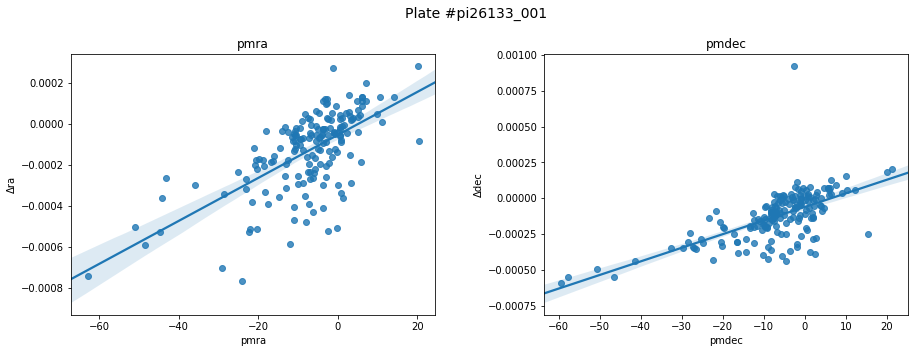

In [71]:
fig = plt.figure(figsize=(15,5))
title = fig.suptitle("Plate #pi26133_001", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3, hspace=0.5)

ax1 = fig.add_subplot(1,2,1)
sns.regplot('pmra','Δra',data=df).set_title('pmra')
ax2 = fig.add_subplot(1,2,2)
sns.regplot('pmdec','Δdec',data=df).set_title('pmdec')

### Regression

In [24]:
df_filtered_ = df_filtered.query('phot_bp_mean_mag>14').dropna()

In [ ]:
import statsmodels.api as sm 

X = df_filtered_["phot_bp_mean_mag"] ## X usually means our input variables (or independent variables)
y = df_filtered_["Magnitude"] ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
#predictions = model.predict(X)

# Print out the statistics
model.summary()

### Match by position and distance

In [26]:
df_gaia = r.to_pandas().dropna().query('phot_bp_mean_mag>14').reset_index(drop=True)
df_apt_ = pd.read_csv(filename).dropna().reset_index(drop=True)
df_apt = df_apt_[['CentroidRA', 'CentroidDec','Magnitude', 'MagUncertainty']]

In [27]:
df_gaia['mag_mod'] = 0.8783*df_gaia.phot_bp_mean_mag-6.1212

In [32]:
maxdiff = 1 #0.001
querystr = "diff<" + str(maxdiff)
df = pd.DataFrame(columns=['ra','dec','phot_bp_mean_mag','pmra','pmdec',\
                           'CentroidRA','CentroidDec','Magnitude','diff'])
dist = scipy.spatial.distance.cdist(df_apt[['CentroidRA', 'CentroidDec']], df_gaia[['ra', 'dec']]) 
dist_mag = scipy.spatial.distance.cdist(df_apt[['Magnitude']], df_gaia[['mag_mod']]) 

tdist = dist*1+dist_mag*0

min_dist = np.argmin(tdist, axis=1) 

m = 0
while m < len(df_apt): 
    n = min_dist[m] 
    df = df.append({'ra': df_gaia['ra'][n], 'dec': df_gaia['dec'][n],\
                    'phot_bp_mean_mag': df_gaia['phot_bp_mean_mag'][n],\
                    'mag_mod': df_gaia['mag_mod'][n],\
                    'pmra': df_gaia['pmra'][n], 'pmdec': df_gaia['pmdec'][n],\
                    'CentroidRA': df_apt['CentroidRA'][m],'CentroidDec': df_apt['CentroidDec'][m],\
                    'Magnitude': df_apt['Magnitude'][m],\
                    'diff': dist[m][n],\
                    'dist_mag': dist_mag[m][n]
                   }, ignore_index=True)
    m+=1


df = df.query(querystr)
df = df.sort_values('diff').drop_duplicates('ra')
df = df.sort_values('diff').drop_duplicates('CentroidRA')
#df= df.reset_index(drop=True)

In [36]:
#new vars
df['Δra'] = df.apply(lambda row: row.ra - row.CentroidRA, axis = 1) 
df['Δdec'] = df.apply(lambda row: row.dec - row.CentroidDec, axis = 1) 
df['Δmag'] = df.apply(lambda row: row.Magnitude - row.phot_bp_mean_mag, axis = 1) 

#subset
df_filtered = df.query('diff<0.0002')

Text(0.5,1,'pmdec')

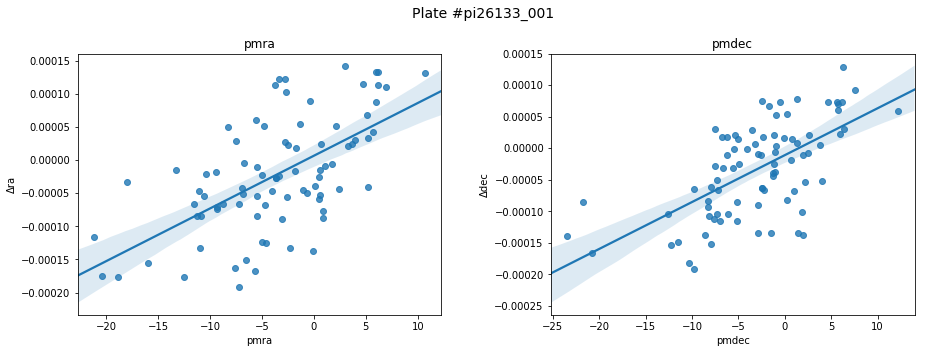

In [40]:
fig = plt.figure(figsize=(15,5))
title = fig.suptitle("Plate #pi26133_001", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3, hspace=0.5)

ax1 = fig.add_subplot(1,2,1)
sns.regplot('pmra','Δra',data=df_filtered).set_title('pmra')
ax2 = fig.add_subplot(1,2,2)
sns.regplot('pmdec','Δdec',data=df_filtered).set_title('pmdec')

/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'dec vs. Δdec')

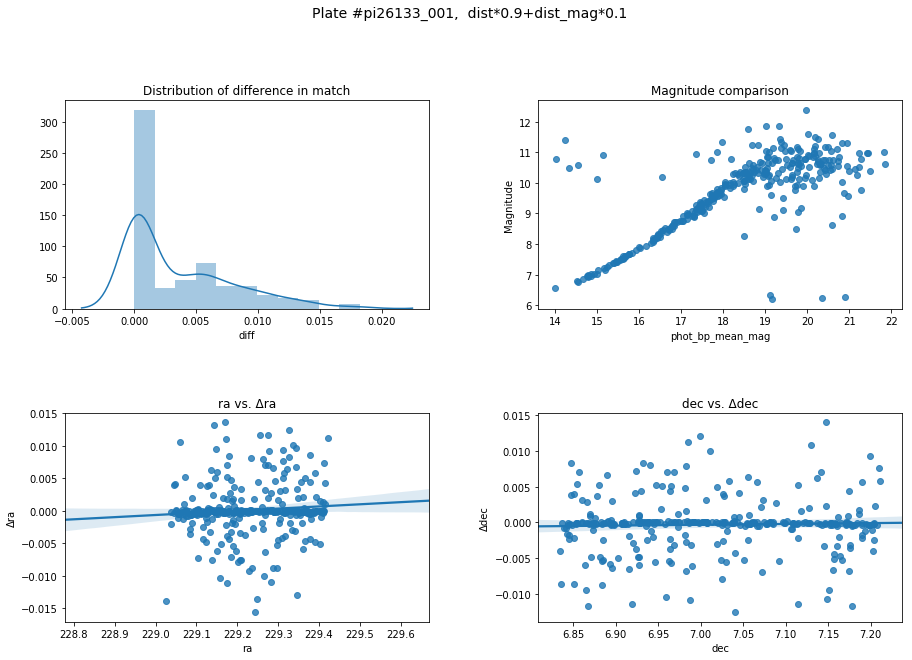

In [37]:
fig = plt.figure(figsize=(15,10))
title = fig.suptitle("Plate #pi26133_001,  dist*0.9+dist_mag*0.1", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3, hspace=0.5)

ax1 = fig.add_subplot(2,2,1)
sns.distplot(df['diff']).set_title('Distribution of difference in match')
ax2 = fig.add_subplot(2,2,2)
sns.regplot('phot_bp_mean_mag','Magnitude',data=df, fit_reg = False).set_title('Magnitude comparison')
ax3 = fig.add_subplot(2,2,3)
sns.regplot('ra','Δra',data=df).set_title('ra vs. Δra')
ax4 = fig.add_subplot(2,2,4)
sns.regplot('dec','Δdec',data=df).set_title('dec vs. Δdec')

Text(0.5,1,'pmdec')

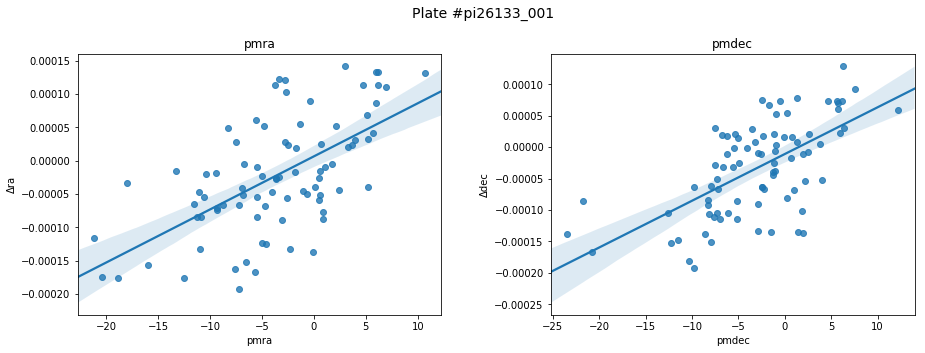

In [39]:
fig = plt.figure(figsize=(15,5))
title = fig.suptitle("Plate #pi26133_001", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3, hspace=0.5)

ax1 = fig.add_subplot(1,2,1)
sns.regplot('pmra','Δra',data=df_filtered).set_title('pmra')
ax2 = fig.add_subplot(1,2,2)
sns.regplot('pmdec','Δdec',data=df_filtered).set_title('pmdec')